In [1]:
from libero.libero import benchmark, get_libero_path, set_libero_default_path
import os
from termcolor import colored

benchmark_root_path = get_libero_path("benchmark_root")
init_states_default_path = get_libero_path("init_states")
datasets_default_path = get_libero_path("datasets")
bddl_files_default_path = get_libero_path("bddl_files")
print("Default benchmark root path: ", benchmark_root_path)
print("Default dataset root path: ", datasets_default_path)
print("Default bddl files root path: ", bddl_files_default_path)

Default benchmark root path:  /home/ruiqi/projects/LIBERO/libero/libero
Default dataset root path:  /home/ruiqi/projects/LIBERO/libero/libero/../datasets
Default bddl files root path:  /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files


In [2]:
print(init_states_default_path)

/home/ruiqi/projects/LIBERO/libero/libero/./init_files


In [4]:
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict["libero_object"](1)  # 1 defines the corresponding task order. 0: [0,1,2,3..9]
num_tasks = benchmark_instance.get_num_tasks()
print(num_tasks)

[info] using task orders [4, 6, 8, 7, 3, 1, 2, 0, 9, 5]
10


In [5]:
task_names = benchmark_instance.get_task_names()
print("The benchmark contains the following tasks:")
for i in range(num_tasks):
    task_name = task_names[i]
    task = benchmark_instance.get_task(i)
    bddl_file = os.path.join(bddl_files_default_path, task.problem_folder, task.bddl_file)
    print(f"\t {task_name}, detail definition stored in {bddl_file}")

The benchmark contains the following tasks:
	 pick_up_the_ketchup_and_place_it_in_the_basket, detail definition stored in /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files/libero_object/pick_up_the_ketchup_and_place_it_in_the_basket.bddl
	 pick_up_the_butter_and_place_it_in_the_basket, detail definition stored in /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files/libero_object/pick_up_the_butter_and_place_it_in_the_basket.bddl
	 pick_up_the_chocolate_pudding_and_place_it_in_the_basket, detail definition stored in /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files/libero_object/pick_up_the_chocolate_pudding_and_place_it_in_the_basket.bddl
	 pick_up_the_milk_and_place_it_in_the_basket, detail definition stored in /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files/libero_object/pick_up_the_milk_and_place_it_in_the_basket.bddl
	 pick_up_the_bbq_sauce_and_place_it_in_the_basket, detail definition stored in /home/ruiqi/projects/LIBERO/libero/libero/./bddl_files/libero_object

### each task contains 50 different initialization and be set using env.set_init_state(init_states[eval_index])

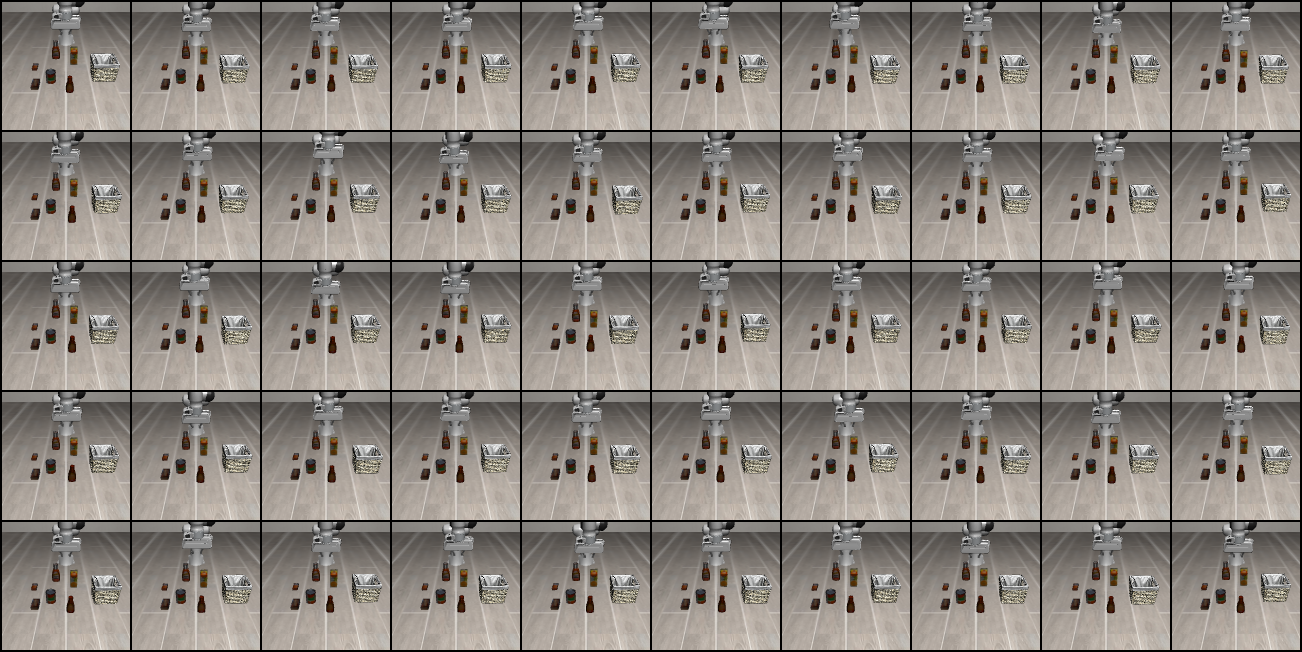

In [6]:
from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision

# task_id is the (task_id + 1)th task in the benchmark
task_id = 1
task = benchmark_instance.get_task(task_id)

env_args = {
    "bddl_file_name": os.path.join(bddl_files_default_path, task.problem_folder, task.bddl_file),
    "camera_heights": 128,
    "camera_widths": 128
}

env = OffScreenRenderEnv(**env_args)

init_states = benchmark_instance.get_task_init_states(task_id)

# Fix random seeds for reproducibility
env.seed(0)


def make_grid(images, nrow=8, padding=2, normalize=False, pad_value=0):
    """Make a grid of images. Make sure images is a 4D tensor in the shape of (B x C x H x W)) or a list of torch tensors."""
    grid_image = torchvision.utils.make_grid(images, nrow=nrow, padding=padding, normalize=normalize,
                                             pad_value=pad_value).permute(1, 2, 0)
    return grid_image


images = []
env.reset()
for eval_index in range(len(init_states)):
    env.set_init_state(init_states[eval_index])

    for _ in range(5):
        obs, _, _, _ = env.step([0.] * 7)
    images.append(torch.from_numpy(obs["agentview_image"]).permute(2, 0, 1))

# # images = torch.stack(images, dim=0).permute(0, 3, 1, 2)
# print(images.shape)
grid_image = make_grid(images, nrow=10, padding=2, pad_value=0)
display(Image.fromarray(grid_image.numpy()[::-1]))
env.close()

In [8]:
# Check if the demo files exist
demo_files = [os.path.join(datasets_default_path, benchmark_instance.get_task_demonstration(i)) for i in
              range(num_tasks)]
for demo_file in demo_files:
    if not os.path.exists(demo_file):
        print(colored(f"[error] demo file {demo_file} cannot be found. Check your paths", "red"))

In [10]:
demo_files[0]

'/home/ruiqi/projects/LIBERO/libero/libero/../datasets/libero_object/pick_up_the_ketchup_and_place_it_in_the_basket_demo.hdf5'

## get the dataset for previous 5 tasks and sequential dataset for the rest 5, each task has 50 demonstration

In [14]:
# load the default config
from hydra import compose, initialize
import hydra
from omegaconf import OmegaConf
import yaml
from easydict import EasyDict
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="../libero/configs")
hydra_cfg = compose(config_name="config")
yaml_config = OmegaConf.to_yaml(hydra_cfg)
cfg = EasyDict(yaml.safe_load(yaml_config))


/tmp/ipykernel_28713/3656217403.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../libero/configs")


In [18]:
cfg.data.obs.modality

{'rgb': ['agentview_rgb', 'eye_in_hand_rgb'],
 'depth': [],
 'low_dim': ['gripper_states', 'joint_states']}

'/home/ruiqi/projects/LIBERO/libero/libero/../datasets'

In [40]:
from torch.utils.data import ConcatDataset, Dataset
from libero.lifelong.datasets import get_dataset, SequenceVLDataset
from libero.libero.utils.dataset_utils import get_dataset_info
from libero.lifelong.utils import (
    NpEncoder,
    compute_flops,
    control_seed,
    safe_device,
    torch_load_model,
    create_experiment_dir,
    get_task_embs,
)
# prepare datasets from the benchmark
manip_datasets = []
descriptions = []
shape_meta = None

for i in range(num_tasks):
    # currently we assume tasks from same benchmark have the same shape_meta
    try:
        task_i_dataset, shape_meta = get_dataset(
            dataset_path=os.path.join(
                datasets_default_path, benchmark_instance.get_task_demonstration(i)
            ),
            obs_modality=cfg.data.obs.modality,
            initialize_obs_utils=(i == 0),
            seq_len=cfg.data.seq_len,
        )
    except Exception as e:
        print(
            f"[error] failed to load task {i} name {benchmark_instance.get_task_names()[i]}"
        )
        print(f"[error] {e}")
    # add language to the vision dataset, hence we call vl_dataset
    task_description = benchmark_instance.get_task(i).language
    descriptions.append(task_description)
    manip_datasets.append(task_i_dataset)

task_embs = get_task_embs(cfg, descriptions) # the description embedding model can be changed in cfg.task_embedding_format
benchmark_instance.set_task_embs(task_embs)

/home/ruiqi/miniconda3/envs/libero/lib/python3.8/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):



============= Initialized Observation Utils with Obs Spec =============

using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: low_dim with keys: ['gripper_states', 'joint_states']
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 1240.88it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 668.47it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 863.49it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 733.05it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 774.37it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 2578.95it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 723.32it/s]
SequenceDataset: loading dataset into memory...
100%|██████

In [47]:
# print out the dataset size for each task
for i in range(num_tasks):
    print(f'{descriptions[i]}: size {len(manip_datasets[i])}')

pick up the ketchup and place it in the basket: size 8056
pick up the butter and place it in the basket: size 7865
pick up the chocolate pudding and place it in the basket: size 7982
pick up the milk and place it in the basket: size 7281
pick up the bbq sauce and place it in the basket: size 7348
pick up the cream cheese and place it in the basket: size 7194
pick up the salad dressing and place it in the basket: size 6641
pick up the alphabet soup and place it in the basket: size 7808
pick up the orange juice and place it in the basket: size 6968
pick up the tomato sauce and place it in the basket: size 7364


In [50]:
manip_datasets[1].total_num_sequences

7865

In [51]:
from libero.lifelong.datasets import GroupedTaskDataset
datasets = []
n_demos = []
n_sequences = []

dataset = GroupedTaskDataset(
    manip_datasets[0 : 5], task_embs[0 : 5]
)
# datasets.append(dataset)
# n_demos.extend([x.n_demos for x in dataset.sequence_datasets])
# n_sequences.extend(
#     [x.total_num_sequences for x in dataset.sequence_datasets]
# )

In [52]:
single_data = dataset[0]
print(single_data.keys())

dict_keys(['actions', 'obs', 'task_emb'])


In [58]:
print(single_data['obs'].keys())

dict_keys(['agentview_rgb', 'eye_in_hand_rgb', 'gripper_states', 'joint_states'])


### create the sequential dataset for the rest 5 tasks

In [60]:
rest_dataset = manip_datasets[5:]
rest_task_embs = task_embs[5:]
adapt_datasets = [
            SequenceVLDataset(ds, emb) for (ds, emb) in zip(rest_dataset, rest_task_embs)
        ]

5